In [1]:
# Imports
import math
import matplotlib.pyplot as plt

# Define parameters
b = 300                             # Beam width
h = 450                             # Beam height
clearance = 50                      # Clearance from tension steel to bottom of concrete
d = h - clearance                   # d - Effective depth
d_prime = 50                        # d' - Distance from compression steel to concrete compression fiber
fcprime = 21                        # f'c - Concrete compressive strength
fy = 275                            # fy - Steel tensile strength
fr = 0.6 * math.sqrt(fcprime)       # Modulus of fructure
Es = 200000                         # Modulus of elasticity of steel
Ec = 4700 * math.sqrt(fcprime)      # Modulus of elasticity of concrete
β1 = 0.85                           # Beta
η = Es / Ec                         # Modular ratio

# As balance
ρb = (0.85 * fcprime * β1 * 600) / (fy * (600 + fy)) # Balance concret-steel ratio
Asb = ρb * b * d                    # As balance

# Cases
As = [Asb, 0.5*Asb, 1.2 * Asb]       # Tension reinforcements
AsPrime = [0.0, 0.0, 0.7*Asb]      # Compression reinforcements

# Data holders
M = ([], [], [])                    # Array of moments for the 3 cases
ϕ = ([], [], [])                    # Array of curvature for the 3 cases
I = ([], [], [])                    # Array of all computed moment of inertias
kd = ([], [], [])                   # Array of values of neutral axis to compression fiber
fsm = ([], [], [])                  # Array of strains in concrete
yield_pts = []

In [2]:
print('Ec = ', Ec)
print('η = ', η)
print('Asb = ', Asb)
print('fr = ', fr)

Ec =  21538.105766292447
η =  9.285867669616698
Asb =  4539.927272727273
fr =  2.7495454169735036


In [3]:
# =========================================
# Utilities
# =========================================
def solveLo(case_no, 𝜆):
    if case_no ==1:
        return 0.85 / 3 * 𝜆 * (3 - 𝜆)
    else:
        return 0.85 * (3*𝜆 - 1) / (3 * 𝜆)

In [4]:
# Insert initial values for moment and curvature
for i in range(3):
    M[i].append(0.0)
    ϕ[i].append(0.0)

# Calculate for ⲉo
ⲉo = 2 * 0.85 * fcprime / Ec
    
for i in range(3):
    print('=======================================')
    print('Case No.', i+1)
    print('=======================================')
    # =========================================== #
    # Calculation before cracking                 #
    # =========================================== #
    # Calculate for kd of each case
    print('Stage 1: Before and after cracking')
    At = b * h                                          # Concrete alone
    At += (η-1) * As[i]                                 # Concrete plus transformed tension steel
    At += (η-1) * AsPrime[i]                            # Plus transformed compression steel
    Ma = (b * h) * (h / 2)                              # Moment of area of concrete to compression fiber
    Ma += (η-1) * As[i] * d                             # Moment of tension reinf. to compression fiber
    Ma += (η-1) * AsPrime[i] * d_prime                  # Moment of compression reinf. to compression fiber
    kdCalculated = Ma / At
    kd[i].append(kdCalculated)                          # Insert to list of kd

    # Calculate for moment of inertia of each case
    Ic = (b * kdCalculated**3 / 12) + (b * kdCalculated * (kdCalculated / 2)**2)
    Ic += (b * (h - kdCalculated)**3 / 12) + (b * (h - kdCalculated) * ((h - kdCalculated) / 2)**2)
    Ic += (η-1) * As[i] * (d - kdCalculated)**2
    Ic += (η-1) * AsPrime[i] * (kdCalculated - d_prime)**2
    I[i].append(Ic)                                     # Insert to list of I
    
    # Calculate the cracking moment
    ⲉc = (fr / Ec) / (h - kdCalculated) * kdCalculated
    print('ⲉc = ', ⲉc)
    fc = ⲉc * Ec
    print('fc = ', fc, 'MPa')
    ⲉsPrime = ⲉc / kdCalculated * (kdCalculated - d_prime)
    fsPrime = ⲉsPrime * Es
    print('fs\' = ', fsPrime)
    𝜆o = ⲉc / ⲉo
    print('𝜆o = ', 𝜆o)
    k2 = 1 / 4 * (4 - 𝜆o) / (3 - 𝜆o)
    print('k2 = ', k2)
    Lo = solveLo(1, 𝜆o)
    print('Lo = ', Lo)
    
    Mcr = Lo * fc * b * kdCalculated * (d - k2 * kdCalculated) +\
                AsPrime[i] * fsPrime * (d - d_prime)
    
    M[i].append(Mcr)                                    # Insert to list of M
    
    # Calculate the curvature
    ϕc = ⲉc / kdCalculated
    ϕ[i].append(ϕc)                                     # Insert to list of ϕ
    
    print('Mcr = ', round(Mcr / 1000**2, 2), 'ϕc = ', ϕc, 'kd = ', kdCalculated, "Before cracking...")
    
    # =========================================== #
    # Calculation after cracking                  #
    # =========================================== #
    # Finding the neutral axis using equilibrium of moment of areas
    # b(kd)(kd/2) + (n-1)As'(kd-d') = nAs(d-kd)
    # -- solve the quadratic equation
    qa = b
    qb = 2 * ((η-1) * AsPrime[i] + η * As[i])
    qc = -2 * ((η-1) * AsPrime[i] * d_prime + η * As[i] * d)
    qd = (qb**2) - (4 * qa * qc)                        # Discriminant
    kdCalculated = (-1 * qb + math.sqrt(qd)) / (2 * qa) # Neutral axis after cracking
    kd[i].append(kdCalculated)
    
    print('kd (after crack) = ', kdCalculated)
    
    # Calculate the curvature
    ϕc = ⲉc / kdCalculated
    
    M[i].append(Mcr)
    ϕ[i].append(ϕc)
    print('Mcr = ', round(Mcr / 1000**2, 2), 'ϕc = ', ϕc, 'kd = ', kdCalculated, "After cracking...")
    # =========================================== #
    # Calculation at yield point                  #
    # =========================================== #
    fc = 0.5 * fcprime
    ⲉc = fc / Ec
    print('ⲉc (yield point) = ', ⲉc)
    𝜆o = ⲉc / ⲉo
    k2 = 1 / 4 * (4 - 𝜆o) / (3 - 𝜆o)
    Lo = solveLo(1, 𝜆o)
    fc = 0.85 * fcprime * (2 * 𝜆o - 𝜆o**2)
    kdCalculated = (As[i] - AsPrime[i]) * fy / (Lo * fc * b)
    fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
    fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)

    if fs >= fy:                                    # Tension steel yields
        # Solve for the stress in compression steel
        if fsPrime < fy:                           
            # Compression steel does not yields
            qa = Lo * fc * b
            qb = (Es * ⲉc) * AsPrime[i] - As[i] * fy
            qc = -(Es * ⲉc) * AsPrime[i] * d_prime
            qd = (qb**2) - (4 * qa * qc)           # Discriminant
            kdCalculated = (-1 * qb + math.sqrt(qd)) / (2 * qa)
            fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
            fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
            print('Tension steel yields but compression steel did not.')
        else:
            # fs and fs' > fy
            kdCalculated = (As[i] - AsPrime[i]) * fy / (Lo * fc * b)
            fs = fy
            fsPrime = fy
            print('Both tension and compression steel yields.')
    else:
        qa = Lo * fc * b
        qb = AsPrime[i] * fy + As[i] * Es * ⲉc
        qc = -As[i] * Es * ⲉc * d
        qd = (qb**2) - (4 * qa * qc)           # Discriminant
        kdCalculated = (-1 * qb + math.sqrt(qd)) / (2 * qa)
        fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
        fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
            
        if fsPrime < fy:
            # Compression syeel did not yield
            # Compression steel does not yields
            qa = Lo * fc * b
            qb = (Es * ⲉc) * (AsPrime[i] + As[i])
            qc = -(Es * ⲉc) * (As[i] * d + AsPrime[i] * d_prime)
            qd = (qb**2) - (4 * qa * qc)           # Discriminant
            kdCalculated = (-1 * qb + math.sqrt(qd)) / (2 * qa)
            fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
            fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
            print('Both tension and compression steel did not yield')
        else:
            print('Tension steel did not yield but compression does')
        
    Mc = Lo * fc * b * kdCalculated * (d - k2 * kdCalculated) +\
                AsPrime[i] * fsPrime * (d - d_prime)
    ϕc = ⲉc / kdCalculated
    
    M[i].append(Mc)
    ϕ[i].append(ϕc)
    print('fs = ', fs, 'fs\' = ', fsPrime)
    print('Myield = ', round(Mc / 1000**2, 2), 'ϕc = ', ϕc, 'ⲉc = ', ⲉc, 'kd = ', kdCalculated)
    
    yield_pts.append((ϕc*1000, Mc / 1000**2))
    
    # =========================================== #
    # Calculation at inelastic behaviour          #
    # =========================================== #
    
    
    # Iterator increment
    iterator_increment = 0.0002
    
    # For 0 < ⲉc < ⲉo
    # ⲉc = 0.5 * ⲉo                                          # My setting for starting strain iteration
    print('For 0 < ⲉc < ⲉo')
    # For case 0 < ⲉc < ⲉo
    while (ⲉc + iterator_increment) <= ⲉo:
        ⲉc = ⲉc + iterator_increment
        𝜆o = ⲉc / ⲉo
        k2 = 1 / 4 * (4 - 𝜆o) / (3 - 𝜆o)
        Lo = solveLo(1, 𝜆o)
        fc = 0.85 * fcprime * (2 * 𝜆o - 𝜆o**2)
        kdCalculated = (As[i] - AsPrime[i]) * fy / (Lo * fc * b)
        fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
        fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
        
        if fs >= fy:                                    # Tension steel yields
            # Solve for the stress in compression steel
            if fsPrime < fy:                           
                # Compression steel does not yields
                qa = Lo * fc * b
                qb = (Es * ⲉc) * AsPrime[i] - As[i] * fy
                qc = -(Es * ⲉc) * AsPrime[i] * d_prime
                qd = (qb**2) - (4 * qa * qc)           # Discriminant
                kdCalculated = (-1 * qb + math.sqrt(qd)) / (2 * qa)
                fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
                fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
                print('Tension steel yields but compression steel did not.')
            else:
                # fs and fs' > fy
                kdCalculated = (As[i] - AsPrime[i]) * fy / (Lo * fc * b)
                fs = fy
                fsPrime = fy
                print('Both tension and compression steel yields.')
        else:
            qa = Lo * fc * b
            qb = AsPrime[i] * fy + As[i] * Es * ⲉc
            qc = -As[i] * Es * ⲉc * d
            qd = (qb**2) - (4 * qa * qc)           # Discriminant
            kdCalculated = (-1 * qb + math.sqrt(qd)) / (2 * qa)
            fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
            fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
            
            if fsPrime < fy:
                # Compression syeel did not yield
                # Compression steel does not yields
                qa = Lo * fc * b
                qb = (Es * ⲉc) * (AsPrime[i] + As[i])
                qc = -(Es * ⲉc) * (As[i] * d + AsPrime[i] * d_prime)
                qd = (qb**2) - (4 * qa * qc)           # Discriminant
                kdCalculated = (-1 * qb + math.sqrt(qd)) / (2 * qa)
                fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
                fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
                print('Both tension and compression steel did not yield')
            else:
                print('Tension steel did not yield but compression does')
        
        Mc = Lo * fc * b * kdCalculated * (d - k2 * kdCalculated) +\
                AsPrime[i] * fsPrime * (d - d_prime)
        ϕc = ⲉc / kdCalculated
        
        M[i].append(Mc)
        ϕ[i].append(ϕc)
        
        print('Mc = ', round(Mc / 1000**2, 2), 'ϕc = ', round(ϕc, 8), 'ⲉc = ', round(ⲉc, 5), 'kd = ', round(kdCalculated, 0))
    
    print("For ⲉo < ⲉc < ⲉcu")
    # For case ⲉo < ⲉc < ⲉcu
    ⲉc = ⲉo + 0.0001
    while (ⲉc + iterator_increment) <= 0.003:
        ⲉc = ⲉc + iterator_increment
        ζc = ⲉo / ⲉc
        𝜆o = 1 / ζc
        Lo = solveLo(2, 𝜆o)
        k2 = (6 * 𝜆o**2 - 4 * 𝜆o + 1) / (4 * 𝜆o * (3 * 𝜆o - 1))
        fc = 0.85 * fcprime
        kdCalculated = (As[i] - AsPrime[i]) * fy / (Lo * fc * b)
        fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
        fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
        
        if fs >= fy:                                    # Tension steel yields
            # Solve for the stress in compression steel
            if fsPrime < fy:                           
                # Compression steel does not yields
                qa = Lo * fc * b
                qb = (Es * ⲉc) * AsPrime[i] - As[i] * fy
                qc = -(Es * ⲉc) * AsPrime[i] * d_prime
                qd = (qb**2) - (4 * qa * qc)           # Discriminant
                kdCalculated = (-1 * qb + math.sqrt(qd)) / (2 * qa)
                fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
                fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
                print('Tension steel yields but compression steel did not.')
            else:
                # fs and fs' > fy
                kdCalculated = (As[i] - AsPrime[i]) * fy / (Lo * fc * b)
                fs = fy
                fsPrime = fy
                print('Both tension and compression steel yields.')
        else:
            qa = Lo * fc * b
            qb = AsPrime[i] * fy + As[i] * Es * ⲉc
            qc = -As[i] * Es * ⲉc * d
            qd = (qb**2) - (4 * qa * qc)           # Discriminant
            kdCalculated = (-1 * qb + math.sqrt(qd)) / (2 * qa)
            fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
            fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
            
            if fsPrime < fy:
                # Compression syeel did not yield
                # Compression steel does not yields
                qa = Lo * fc * b
                qb = (Es * ⲉc) * (AsPrime[i] + As[i])
                qc = -(Es * ⲉc) * (As[i] * d + AsPrime[i] * d_prime)
                qd = (qb**2) - (4 * qa * qc)           # Discriminant
                kdCalculated = (-1 * qb + math.sqrt(qd)) / (2 * qa)
                fs = (Es * ⲉc) * (d - kdCalculated) / kdCalculated
                fsPrime = Es * ⲉc / kdCalculated * (kdCalculated - d_prime)
                print('Both tension and compression steel did not yield')
            else:
                print('Tension steel did not yield but compression does')
            
        Mc = Lo * fc * b * kdCalculated * (d - k2 * kdCalculated) +\
                AsPrime[i] * fsPrime * (d - d_prime)
        ϕc = ⲉc / kdCalculated
        
        print('Mc = ', round(Mc / 1000**2, 2), 'ϕc = ', round(ϕc, 8), 'ⲉc = ', round(ⲉc, 5), 'kd = ', round(kdCalculated, 0))
        ϕ[i].append(ϕc)
        M[i].append(Mc)

Case No. 1
Stage 1: Before and after cracking
ⲉc =  0.0001797670070736581
fc =  3.8718408116422904 MPa
fs' =  29.121699602692882
𝜆o =  0.10845492469586249
k2 =  0.3364589669153626
Lo =  0.0888539859624273
Mcr =  8.46 ϕc =  6.831701812038738e-07 kd =  263.13649515099587 Before cracking...
kd (after crack) =  223.02262969808856
Mcr =  8.46 ϕc =  8.060482800198944e-07 kd =  223.02262969808856 After cracking...
ⲉc (yield point) =  0.0004875080526548766
Both tension and compression steel did not yield
fs =  38.319023307097204 fs' =  80.52403130121625
Myield =  52.48 ϕc =  1.6977579229759066e-06 ⲉc =  0.0004875080526548766 kd =  287.1481534896038
For 0 < ⲉc < ⲉo
Both tension and compression steel did not yield
Mc =  89.09 ϕc =  2.52e-06 ⲉc =  0.00069 kd =  273.0
Both tension and compression steel did not yield
Mc =  127.38 ϕc =  3.36e-06 ⲉc =  0.00089 kd =  264.0
Both tension and compression steel did not yield
Mc =  164.18 ϕc =  4.19e-06 ⲉc =  0.00109 kd =  260.0
Both tension and compressio

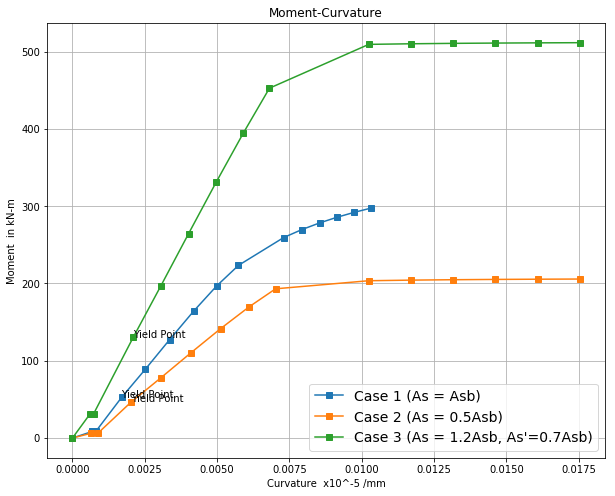

In [5]:
# Convert the values of data to smaller figures
ϕ_converted = ([], [], [])
M_converted = ([], [], [])
for i in range(3):
    for curvature in ϕ[i]:
        ϕ_converted[i].append(curvature * 1000)
    for moment in M[i]:
        M_converted[i].append(moment / 1000**2)
        
# Plot the curves
plt.figure(figsize=(10,8))
plt.title("Moment-Curvature")
plt.xlabel('Curvature  x10^-5 /mm')
plt.ylabel('Moment  in kN-m')
plt.grid()

for yp in yield_pts:
    plt.text(yp[0], yp[1], 'Yield Point')

# Plot the converted values
case1, = plt.plot(ϕ_converted[0], M_converted[0], marker='s', label='Case 1 (As = Asb)')
case2, = plt.plot(ϕ_converted[1], M_converted[1], marker='s', label='Case 2 (As = 0.5Asb)')
case3, = plt.plot(ϕ_converted[2], M_converted[2], marker='s', label='Case 3 (As = 1.2Asb, As\'=0.7Asb)')
plt.legend(handles=[case1, case2, case3], loc='best', fontsize=14)
plt.show()